<center>
<hr>
<h1>Digital Epidemiology</h1>
<h2>Master in Data Science - Sapienza University</h2>
<h2>A.A. 2016/17</h2>
<h2>Paolo Tamagnini</h2>
<h3>ASSIGNMENT #1</h3>
<hr>
</center>

In [1]:
# Paolo Tamagnini
# paolotamag@gmail.com
# 1536242

# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import collections
import random as rnd
import operator
import matplotlib.patches as mpatches
import time

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Part 1.1
<p>I decided to use a graph of Facebook users downloaded from the SNAP data repository (https://snap.stanford.edu/data/egonets-Facebook.html).</p>
<p>The graph is fully connected and the next cell will print some stats and plot the degree distribution.</p> 

Computing degree sequence..
Plotting..


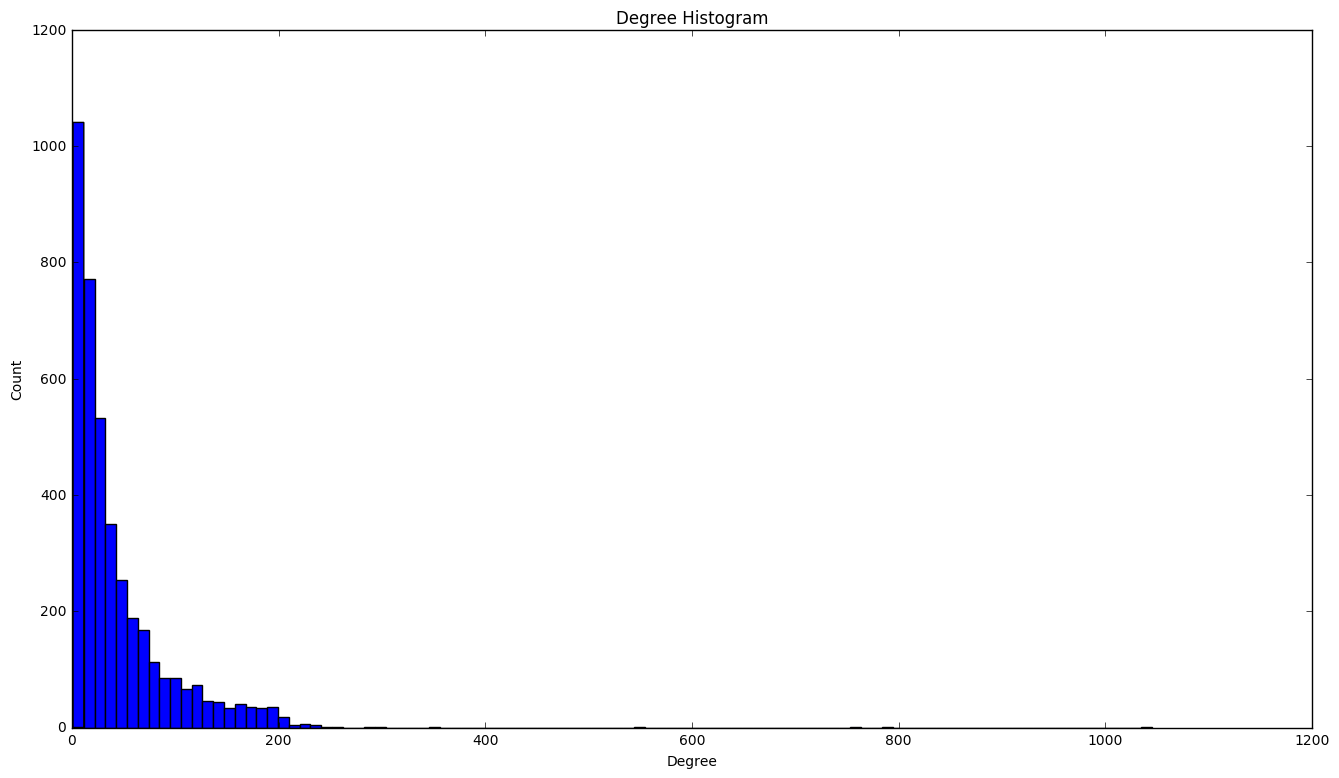


The graph is fully connected: True
Number of components: 1
Number of nodes: 4039
Number of edges: 88233
Average degree: 43.6905174548
Maximum degree: 1045
Minimum degree: 1



In [3]:
fb_graph = pd.read_csv("../data/facebook_combined.txt", delimiter = " ")
G=nx.Graph()
fromList = list(fb_graph['0'])
toList = list(fb_graph['1'])
for x in zip(fromList,toList):
    G.add_edge(x[0],x[1])
N = len(G.nodes())

print 'Computing degree sequence..'

degree_sequence=sorted([d for d in G.degree().values()], reverse=True) # degree sequence
max_deg = np.max(degree_sequence)
min_deg = np.min(degree_sequence)



print "Plotting.."
width_image = 16
height_image = 9
plt.figure(figsize=(width_image, height_image))
plt.hist(degree_sequence, bins = 100)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

plt.show()

print
print "The graph is fully connected:",nx.is_connected(G)
print "Number of components:",nx.number_connected_components(G)
print "Number of nodes:",N
print "Number of edges:",nx.number_of_edges(G)
print "Average degree:",np.mean(G.degree().values())
print "Maximum degree:",max_deg
print "Minimum degree:",min_deg
print 


### Part 1.2
<h3>Initialization</h3>
<p>In the following cell we will initialize and draw the epidemy. As you can see there is lots of coding necessary to color properly the graph. The color green will be used for the class S and its edges, red for I and black for R.</p>
<p>We chose $ \beta = 0.15 $ and $ \mu = 0.1 $ to express an epidemic which is lasting around 70 periods, so we can better analyze its different behaviours. This is due $ R_{0} = \frac{\beta}{\mu} = 1.5 < 2 $ and this means that the spreading of the infection is not exponential.</p> 
<p>We are setting in the initialization just one infected node that should start the epidemy. To make sure the epidemy starts right away, we pick the node with the highest degree.</p>

---
beta: 0.15
mu: 0.1
---


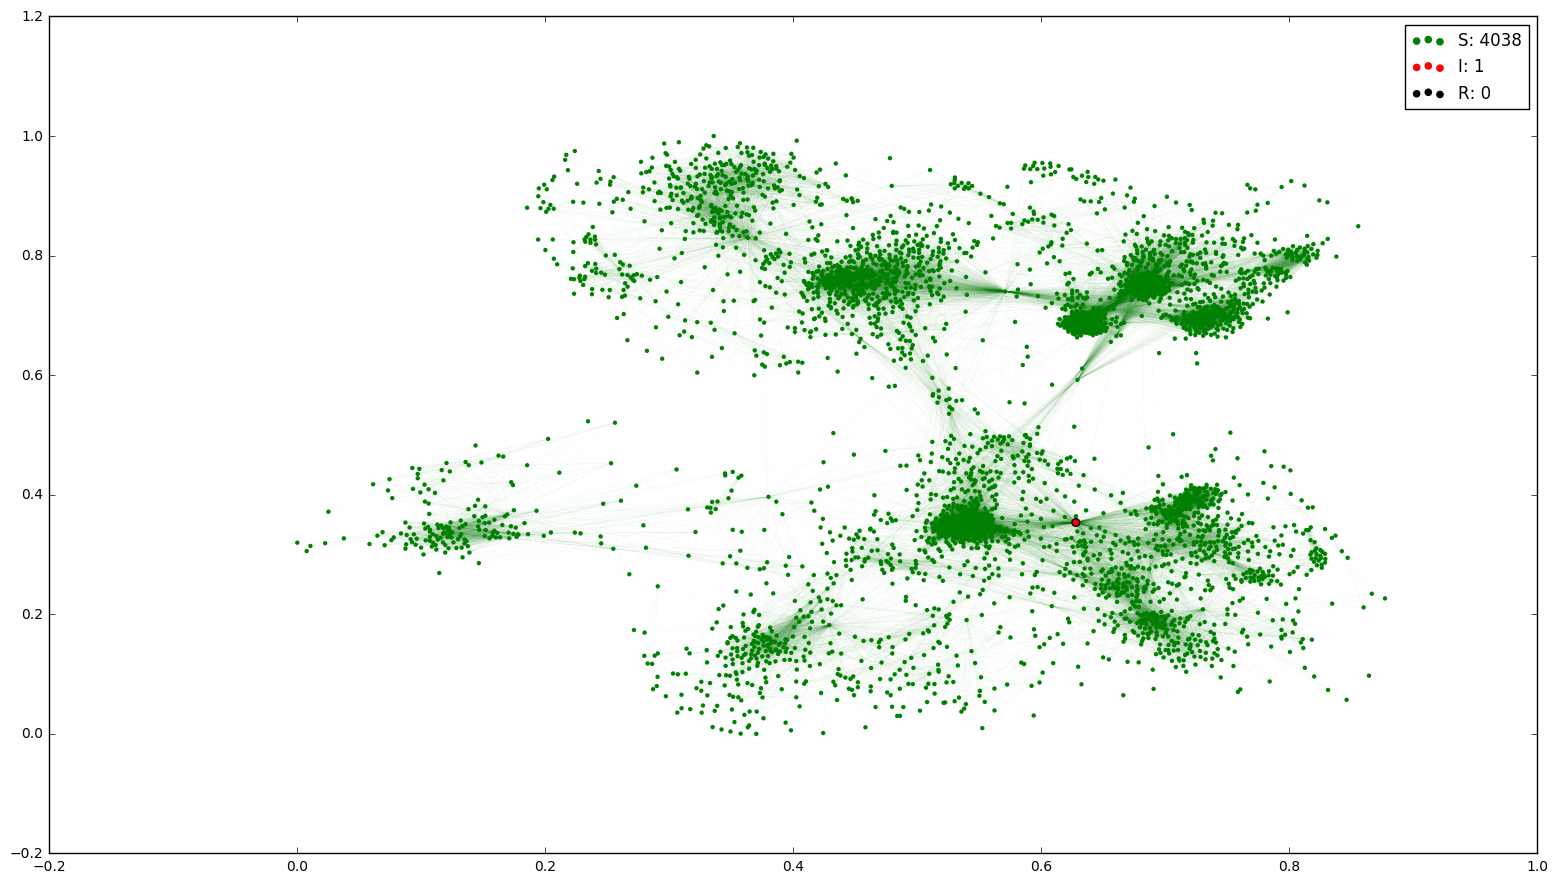

In [5]:
rnd.seed(4321)
initial_pos = {}
for x in G.nodes():
    initial_pos[x] = (rnd.uniform(-1.0, +1.0),rnd.uniform(-1.0, +1.0))
size_node = 10
width_edge = 0.0125
width_image = 19.2
height_image = 10.8

S_chain = []
I_chain = []
R_chain = []
infected_start = 1
I_count = infected_start
S_count = N-I_count
R_count = 0
S_chain.append(S_count)
I_chain.append(I_count)
R_chain.append(R_count)

maxPeriod = 1000
year = 0

maxdegreeNode = max(G.degree().iteritems(), key=operator.itemgetter(1))[0]

mu = 0.1
R0 = 1.5
b = R0*mu

print '---'
print "beta:", b
print "mu:", mu
print '---'

d_attr_status = {}
for i in range(0,N):
    d_attr_status[i] = "S"
d_attr_status[maxdegreeNode] = "I"
nx.set_node_attributes(G,'status',d_attr_status)


d_c_e = {}
for x in G.edges():
    d_c_e[x] = 'green'
    
color_edges = []
for x in G.edges():
    color_edges.append(d_c_e[x])

colors_nodes = []
size_nodes = []
border_nodes = []
for x in G.nodes():
    if x == maxdegreeNode:
        border_nodes.append("black")
        size_nodes.append(size_node*3)
    else:
        border_nodes.append("none")
        size_nodes.append(size_node)
    if G.node[x]['status'] in ['I']:
        colors_nodes.append('red')
    if G.node[x]['status'] in ['S']:
        colors_nodes.append('green')
    if G.node[x]['status'] in ['R']:
        colors_nodes.append('black')
pos = nx.spring_layout(G,k=10/np.sqrt(N),pos = initial_pos)
        
plt.figure(figsize=(width_image, height_image))

nodes = nx.draw_networkx_nodes(G, pos,node_size=size_nodes,node_color  = colors_nodes)
nodes.set_edgecolor(border_nodes)
nx.draw_networkx_edges(G, pos,width =width_edge,edge_color=color_edges)

red_patch = plt.scatter([],[], marker='o', color='red')
green_patch = plt.scatter([],[], marker='o', color='green')
black_patch = plt.scatter([],[], marker='o', color='black')

plt.legend((green_patch,red_patch,black_patch),("S: "+str(S_chain[-1]),"I: "+str(I_chain[-1]),"R: "+str(R_chain[-1])))

plt.show()



### Part 1.2
<h3>The Algorithm</h3>
<p>The algorithm works in the following way. In each period we scroll each node and if it is infected (I) then we go through its neighbours. If a neighbour is susceptible (S) we infect it with probability $\beta$. After trying to infect every neighbour, we transform the infected node from infected (I) to recovered (R) with probability $\mu$.</p>
<p>This time we will omit all the codes necessary to draw a graph at each period, but actually this has been done to produce the following video: </p>
<a href="https://youtu.be/2jmT3briETI" target="_blank">
<img src="a.png" height="1000" border="10" /></a>
<p>After running the algorithm we can plot the curves for the SIR model in the cell right after.</p>

In [6]:
while I_count!=0:
    year+=1
    if year %10 == 0:
        print "----- period:", year, "-----"
    if year == maxPeriod:
        print maxPeriod,"periods have passed."
        break
    for x in G.nodes():
        if G.node[x]['status'] in ['I']:
            neigh = G.neighbors(x)
            for ngh in neigh:
                if d_attr_status[ngh] in ['S']:
                    probInf = rnd.random()
                    if probInf < b:
                        d_attr_status[ngh] = 'I'
                        I_count+=1
                        S_count-=1
            probDeath = rnd.random()
            if probDeath < mu:
                d_attr_status[x] = 'R'
                R_count+=1
                I_count-=1

    S_chain.append(S_count)
    I_chain.append(I_count)
    R_chain.append(R_count)
    nx.set_node_attributes(G,'status',d_attr_status)

----- period: 10 -----
----- period: 20 -----
----- period: 30 -----
----- period: 40 -----
----- period: 50 -----
----- period: 60 -----
----- period: 70 -----
----- period: 80 -----


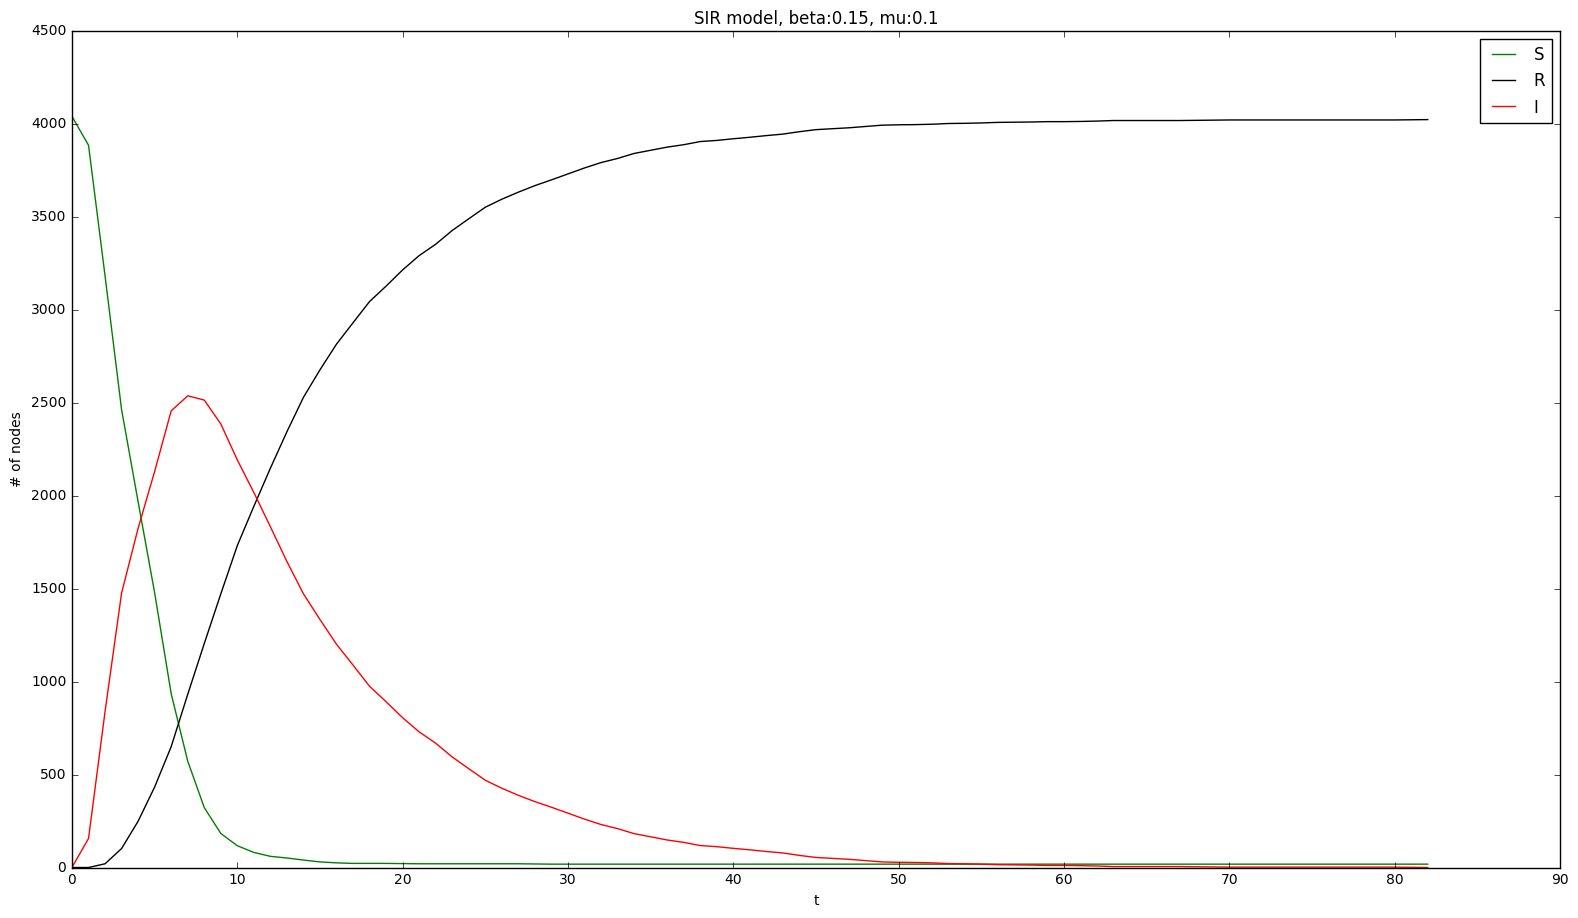

In [7]:
plt.figure(figsize=(width_image, height_image))
plt.plot(S_chain, label='S',color = 'green')
plt.plot(R_chain, label='R',color = 'black')
plt.plot(I_chain, label='I',color = 'red')
plt.legend()
plt.title("SIR model, beta:"+str(b)+", mu:"+str(mu))
plt.xlabel("t")
plt.ylabel("# of nodes")
plt.show()

### Part 2.1 - Part 2.2 - Part 2.3
<p>The following code, is able to output the data of different kind of sentinels. After running it, we will have available data to plot the distributions of time arrivals of the infection on all kind of sentinel set. The kind of the sentinel set changes with the kind of selection. Every set is made of 40 sentinels from the graph (1 % of the nodes). 
Those are the different ways we used for the selection and the relative identifiers.</p>
<ul>
<li>(Part 2.1):<ul><li>40 random nodes (rnd_one)</li></ul></li>
<li>(Part 2.2):<ul><li>40 random nodes picked 10 different times (rnd_mult)</li></ul></li>
<li>(Part 2.3):
<br>
40 nodes with..
<ul>
<li>..highest degree (T_degr)</li>
<li>..lowest degree (B_degr)</li>
<li>..highest closeness centrality (T_clos)</li>
<li>..lowest closeness centrality (B_clos)</li>
<li>..highest betweenness centrality (T_betw)</li>
<li>..lowest betweenness centrality (B_betw)</li>
<li>..highest eigenvector centrality (T_eig)</li>
<li>..lowest eigenvector centrality (B_eig)</li>
<li>..highest pagerank centrality (T_pr)</li>
<li>..lowest pagerank centrality (B_pr)</li>
<li>..highest hub HITS score (T_hubs)</li>
<li>..lowest hub HITS score (B_hubs)</li>
<li>..highest authority HITS score (T_auth)</li>
<li>..lowest authority HITS score (B_auth)</li>
</ul>
</li>
</ul>
<p>For each case we register the arrival times of the infection for 100 simulations. In the case of "rnd_mult" (Part 2.2), we do it 10 times: instead of doing 100 realizations of the epidemic on always the same 40 different nodes, we make 100 realizations for 10 different set of sentinels. Each set has been randomly drawn every 100 realization. Being each set made of 40 nodes, we acquire 100 time arrivals for each of the 400 sentinels for a total of 4000 time arrivals values which we plot as our distribution. We do all this to make sure the result is not affected by a peculiar pick of nodes, which is likely to happen in "rnd_one".</p>

In [8]:
percSentinel = 0.01
num_of_sentinels =  int(percSentinel*N)
degr = nx.degree_centrality(G)
clos = nx.closeness_centrality(G)
betw = nx.betweenness_centrality(G)
eig = nx.eigenvector_centrality(G)
pr = nx.pagerank(G)
hit = nx.hits(G)
sorted_degr = sorted(degr.items(), key=operator.itemgetter(1),reverse=True)
sorted_clos = sorted(clos.items(), key=operator.itemgetter(1),reverse=True)
sorted_betw = sorted(betw.items(), key=operator.itemgetter(1),reverse=True)
sorted_eig = sorted(eig.items(), key=operator.itemgetter(1),reverse=True)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1),reverse=True)
sorted_hubs = sorted(hit[0].items(), key=operator.itemgetter(1),reverse=True)
sorted_auth = sorted(hit[1].items(), key=operator.itemgetter(1),reverse=True)
TOP_sorted_degr = sorted_degr[:num_of_sentinels]
TOP_sorted_clos = sorted_clos[:num_of_sentinels]
TOP_sorted_betw = sorted_betw[:num_of_sentinels]
TOP_sorted_eig = sorted_eig[:num_of_sentinels]
TOP_sorted_pr = sorted_pr[:num_of_sentinels]
TOP_sorted_hubs = sorted_hubs[:num_of_sentinels]
TOP_sorted_auth = sorted_auth[:num_of_sentinels]
BOTTOM_sorted_degr = sorted_degr[-num_of_sentinels:]
BOTTOM_sorted_clos = sorted_clos[-num_of_sentinels:]
BOTTOM_sorted_betw = sorted_betw[-num_of_sentinels:]
BOTTOM_sorted_eig = sorted_eig[-num_of_sentinels:]
BOTTOM_sorted_pr = sorted_pr[-num_of_sentinels:]
BOTTOM_sorted_hubs = sorted_hubs[-num_of_sentinels:]
BOTTOM_sorted_auth = sorted_auth[-num_of_sentinels:]
TOP_degr_RANK = [x[0] for x in TOP_sorted_degr]
TOP_clos_RANK = [x[0] for x in TOP_sorted_clos]
TOP_betw_RANK = [x[0] for x in TOP_sorted_betw]
TOP_eig_RANK = [x[0] for x in TOP_sorted_eig]
TOP_pr_RANK = [x[0] for x in TOP_sorted_pr]
TOP_hubs_RANK = [x[0] for x in TOP_sorted_hubs]
TOP_auth_RANK = [x[0] for x in TOP_sorted_auth]
BOTTOM_degr_RANK = [x[0] for x in BOTTOM_sorted_degr]
BOTTOM_clos_RANK = [x[0] for x in BOTTOM_sorted_clos]
BOTTOM_betw_RANK = [x[0] for x in BOTTOM_sorted_betw]
BOTTOM_eig_RANK = [x[0] for x in BOTTOM_sorted_eig]
BOTTOM_pr_RANK = [x[0] for x in BOTTOM_sorted_pr]
BOTTOM_hubs_RANK = [x[0] for x in BOTTOM_sorted_hubs]
BOTTOM_auth_RANK = [x[0] for x in BOTTOM_sorted_auth]

rnd.seed(12345)
random_RANK = rnd.sample(G.nodes(),num_of_sentinels)
possible_sentinels = {
    "T_degr" : TOP_degr_RANK,
    "T_clos" : TOP_clos_RANK,
    "T_betw" : TOP_betw_RANK,
    "T_eig" : TOP_eig_RANK,
    "T_pr" : TOP_pr_RANK,
    "T_hubs" : TOP_hubs_RANK,
    "T_auth" : TOP_auth_RANK,
    "B_degr" : BOTTOM_degr_RANK,
    "B_clos" : BOTTOM_clos_RANK,
    "B_betw" : BOTTOM_betw_RANK,
    "B_eig" : BOTTOM_eig_RANK,
    "B_pr" : BOTTOM_pr_RANK,
    "B_hubs" : BOTTOM_hubs_RANK,
    "B_auth" : BOTTOM_auth_RANK,
    "rnd_one" : random_RANK,
    "rnd_mult" : [],
}

In [9]:
def compute_time_arrivals(sentinel_nodes,random_pick):
    # create and empty dictionary that will save the array of arrival times for each sentinel
    d_arrival_times_array = {}
    for x in sentinel_nodes:
        d_arrival_times_array[x] = []

    # select the single infected node as the one with highest degree
    maxdegreeNode = max(G.degree().iteritems(), key=operator.itemgetter(1))[0]

    # set the parameters mu and beta
    mu = 0.1
    R0 = 1.5
    b = R0*mu

    print '---'
    print "beta:", b
    print "mu:", mu
    print '---'
    print

    # set the the number of simulation for each sentinels set to 100
    num_realizations = 100
    # and set a maximum period in which we will stop even thou not all the infected nodes are gone
    maxPeriod = 1000

    for iters in range(0,num_realizations):

        if iters %10 == 0:
            print "pick :",random_pick,"; iter. :", iters+10
            print

        # We initialize the chains of S, I and R    
        S_chain = []
        I_chain = []
        R_chain = []
        infected_start = 1
        I_count = infected_start
        S_count = N-I_count
        R_count = 0
        S_chain.append(S_count)
        I_chain.append(I_count)
        R_chain.append(R_count)

        # we initialize the dictionary that pints out the label for each node
        d_attr_status = {}
        for i in range(0,N):
            d_attr_status[i] = "S"

        #this same dictionary will point out sentinels as well
        for sentinel in sentinel_nodes:
            d_attr_status[sentinel] = "sentinel"
        #the only infected node in the beginning
        d_attr_status[maxdegreeNode] = "I"
        #we import the dictionary in the graph
        nx.set_node_attributes(G,'status',d_attr_status)

        # we start at period t = 0
        year = 0

        # we initialize a dictionary that will save for each sentinel the current arrival time
        sentinel_arrival = {}

        # until all infected nodes are gone
        while I_count!=0:

            # starting new period
            year+=1

            # if all I nodes are not dead yet we stop
            if year == maxPeriod:
                print maxPeriod,"periods have passed."
                break

            # for each node
            for x in G.nodes():
                # if it is infected
                if G.node[x]['status'] in ['I']:

                    neigh = G.neighbors(x)
                    # for each neighbour
                    for ngh in neigh:
                        # we check if it is either susceptible or a suceptible sentinel
                        if d_attr_status[ngh] in ['S','sentinel']:
                            probInf = rnd.random()
                            # if we infect this neighbour (S -> I)
                            if probInf < b:
                                # and if it is a sentinel
                                if G.node[ngh]['status'] in ['sentinel']:
                                    # we save the arrival time in the dictionary
                                    sentinel_arrival[ngh] = year
                                # then we change the label
                                d_attr_status[ngh] = 'I'
                                # and we update the counts
                                I_count+=1
                                S_count-=1

                    probDeath = rnd.random()
                    # then if it recorvers (I -> R)
                    if probDeath < mu:
                        # we flip the label
                        d_attr_status[x] = 'R'
                        R_count+=1
                        I_count-=1
            # updating quantitative chains
            S_chain.append(S_count)
            I_chain.append(I_count)
            R_chain.append(R_count)
            # it is safe now, after going through all the nodes in one period, 
            # to update the graph with the new labels
            nx.set_node_attributes(G,'status',d_attr_status)

        # after all infected are recovered (I = 0)

        # for each sentinel
        for x in sentinel_nodes:
            while True:
                # if it has been infected, 
                try:
                    # we save such value in the relative array
                    d_arrival_times_array[x].append(sentinel_arrival[x])
                    break
                except KeyError:
                    break

    # after 100 simulation of the epidemy we have a dictionary that for each sentinel has an array of arrival times

    # we transform such dictionary in a list of lists
    super_array = []
    for x in d_arrival_times_array:
        super_array.append(d_arrival_times_array[x])
    return super_array

In [10]:
rnd.seed(12345)
list_of_results = {}
# for each kind of sentinel selection
for rank in possible_sentinels:
    print
    print '------------------------------------------------'
    print rank
    print '------------------------------------------------'
    print
    # if it's the multiple random case we will repeat 10 times otherwise 1
    if rank in ['rnd_mult']:
        num_pick = 10
    else:
        num_pick = 1
    
    # we itialize an array that will contain all the data relative to the a kind of  sentinel selection
    huge_array = []
    # repeating then 1 or 10 times we will
    for random_pick in range(0,num_pick):

        # either draw 40 sentinels or select the ones stored
        if rank in ['rnd_mult']:
            sentinel_set = rnd.sample(G.nodes(),num_of_sentinels)
        else:
            sentinel_set = possible_sentinels[rank]
            
        super_array = compute_time_arrivals(sentinel_set,random_pick)
        # in the case of random sentinels with multiple draws,
        # we merge the result with the other result of the others draws
        # otherwise in the other cases we are just merging with a empty list (huge_array)
        huge_array = huge_array + super_array

        print "--------"    
        print 
    #we then bound our list of arrays to the correct label of sentinel selection
    list_of_results[rank] = huge_array
print "Done."


------------------------------------------------
B_eig
------------------------------------------------

---
beta: 0.15
mu: 0.1
---

pick : 0 ; iter. : 10

pick : 0 ; iter. : 20

pick : 0 ; iter. : 30

pick : 0 ; iter. : 40

pick : 0 ; iter. : 50

pick : 0 ; iter. : 60

pick : 0 ; iter. : 70

pick : 0 ; iter. : 80

pick : 0 ; iter. : 90

pick : 0 ; iter. : 100

--------


------------------------------------------------
T_eig
------------------------------------------------

---
beta: 0.15
mu: 0.1
---

pick : 0 ; iter. : 10

pick : 0 ; iter. : 20

pick : 0 ; iter. : 30

pick : 0 ; iter. : 40

pick : 0 ; iter. : 50

pick : 0 ; iter. : 60

pick : 0 ; iter. : 70

pick : 0 ; iter. : 80

pick : 0 ; iter. : 90

pick : 0 ; iter. : 100

--------


------------------------------------------------
B_pr
------------------------------------------------

---
beta: 0.15
mu: 0.1
---

pick : 0 ; iter. : 10

pick : 0 ; iter. : 20

pick : 0 ; iter. : 30

pick : 0 ; iter. : 40

pick : 0 ; iter. : 50

pi

### Part 2.1
<p>It is time now to process the result in order to show the requested outcomes. The first request is the plotting of the distribution of time arrivals for 100 realizations for sentinel. The sentinels have to be drawn at random only once. This has been done for "rnd_one".</p>
<p>You can see below two figures.</p>
<p>The first one represents the boxplots of the 40 sentinels that have been picked at random in the "rnd_one" selection. We have a box plot for each sentinel and I order them by the average time arrival. Each boxplot has been computed from 100 values of the time arrivals of the infection at the a single sentinel. We can see that some are always reached in less than 5 periods and that some other around 10 periods. Rarely one of those 40 sentinel nodes is reached in more than 10 periods.</p>
<p>In the second plot instead we can see the data of the 40 random sentinels merged in only one boxplot. The overall average is then 5.32145584118 and we can see that most of the values are lower than the average but not far from it, while another smaller part is greater but at a big distance, reaching values up to 30 and more.</p>

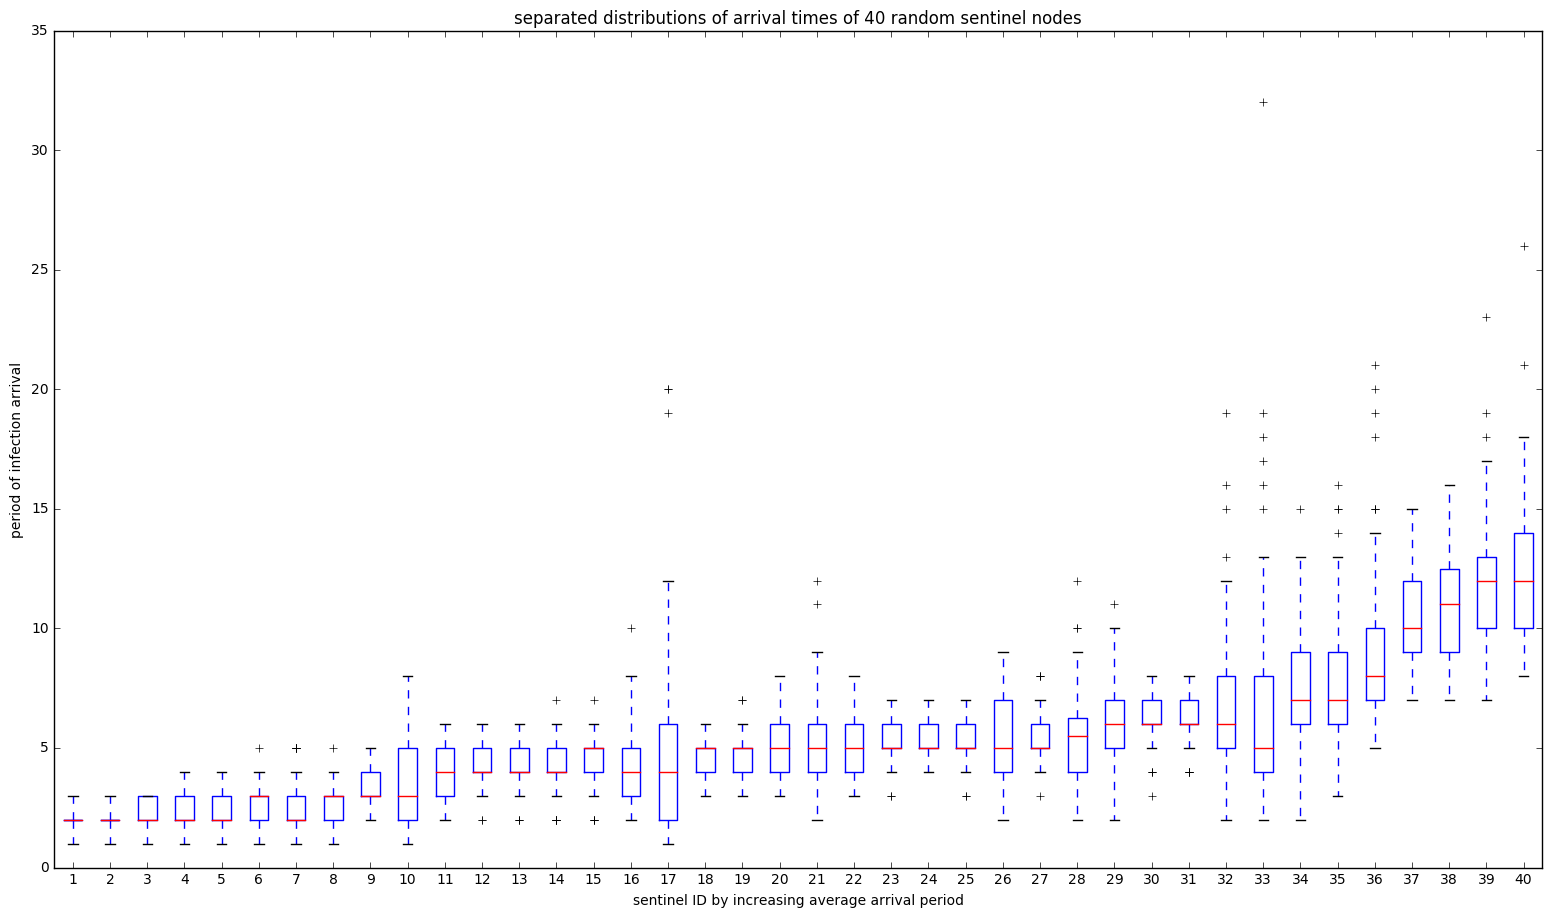


The overall average over all time arrivals is: 5.32145584118



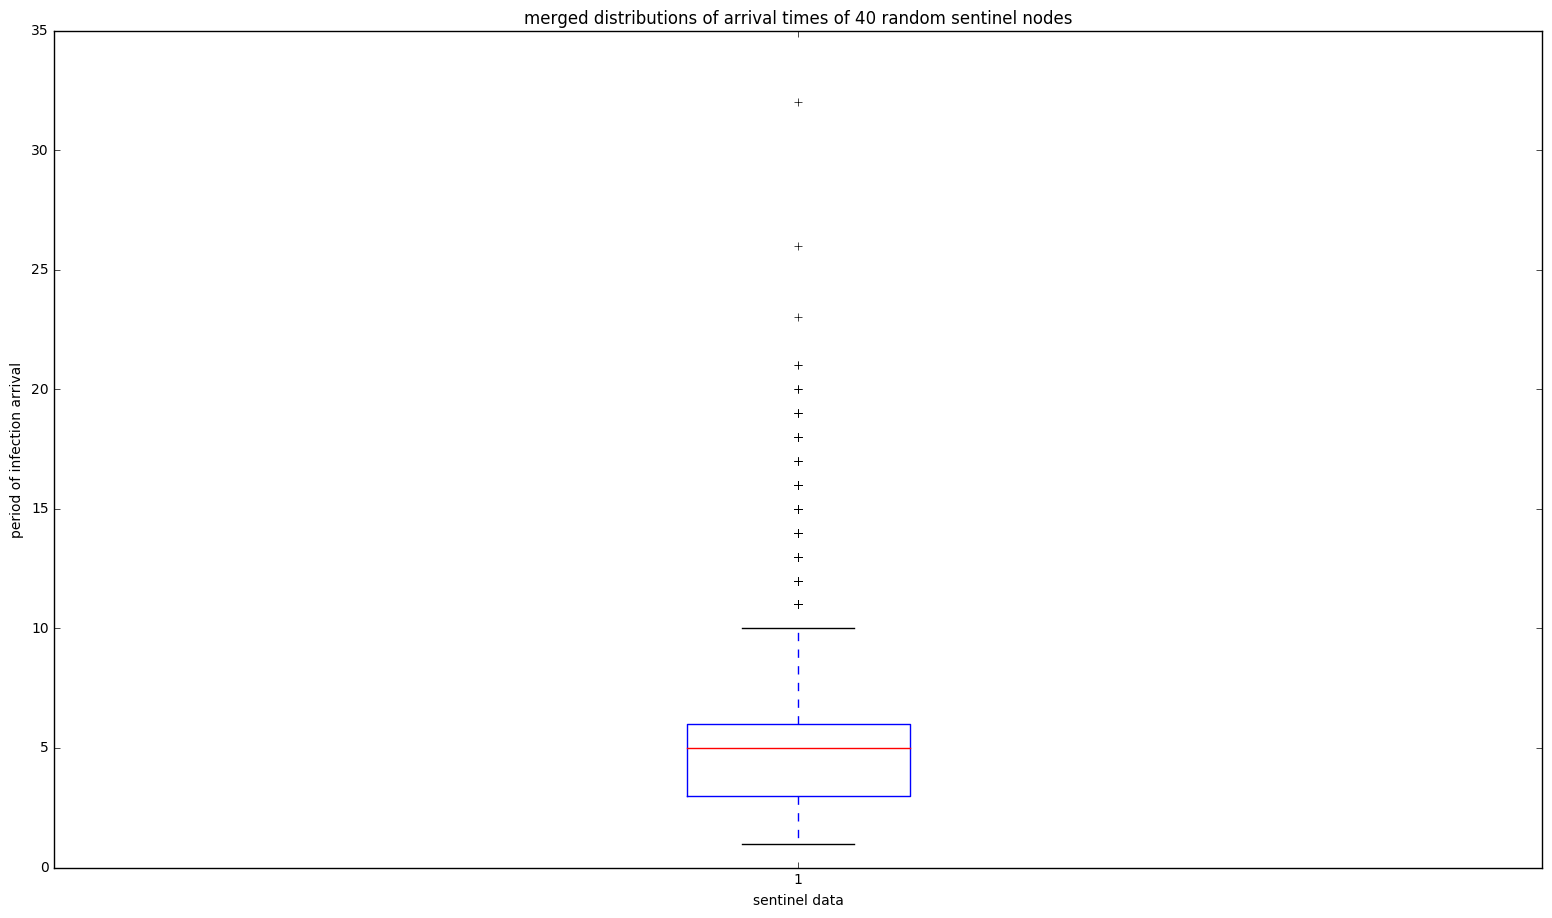

In [12]:
huge_array = list_of_results["rnd_one"]
average_dict = {}
box_plot1=[]
box_plot2=[]

for i in range(0,len(huge_array)):
    box_plot2 = box_plot2 + huge_array[i]
    avg = np.mean(huge_array[i])
    average_dict[i] = avg
sorted_i = sorted(average_dict.items(), key=operator.itemgetter(1))
for a in sorted_i:
    box_plot1.append(huge_array[a[0]])
plt.figure(figsize=(width_image, height_image))
plt.boxplot(box_plot1)
#plt.plot(range(1,len(means)+1),means)
plt.ylabel("period of infection arrival")
plt.xlabel("sentinel ID by increasing average arrival period")
plt.title("separated distributions of arrival times of "+str(len(huge_array))+" random sentinel nodes")
plt.show()
plt.close()
plt.clf()
print
print "The overall average over all time arrivals is:",np.mean(box_plot2)
print
plt.figure(figsize=(width_image, height_image))
plt.boxplot(box_plot2)
#plt.plot(range(1,len(means)+1),means)
plt.ylabel("period of infection arrival")
plt.xlabel("sentinel data")
plt.title("merged distributions of arrival times of "+str(len(huge_array))+" random sentinel nodes")
plt.show()
plt.close()
plt.clf()

### Part 2.2
<p>We will now compare the data relative to the random sentinels we have just seen and the one relative to random sentinels redrawn 10 times. We will see how by redrawing the sentinels we reduce the influence given by the randomness.</p>
<p>The plot below shows 2 boxplots, one for the single random draw (2.1) and the other for the multiple random draw (2.2). By repeating the process 10 times, we get a distribution of data for 400 sentinels: 40 sentinels drawn 10 different times. With each set of 40 sentinels, we make 100 different realization of the epidemic. This means that while the boxplot on the left shows a distribution for 400 values, the one on the right displays one for 4000 values. This last distribution is then way more accurate and it tells us that in the average arrival time is a bit lower : 4.72567376602.

the average arrival for rnd_one is: 5.32145584118
the average arrival for rnd_mult is: 4.72567376602


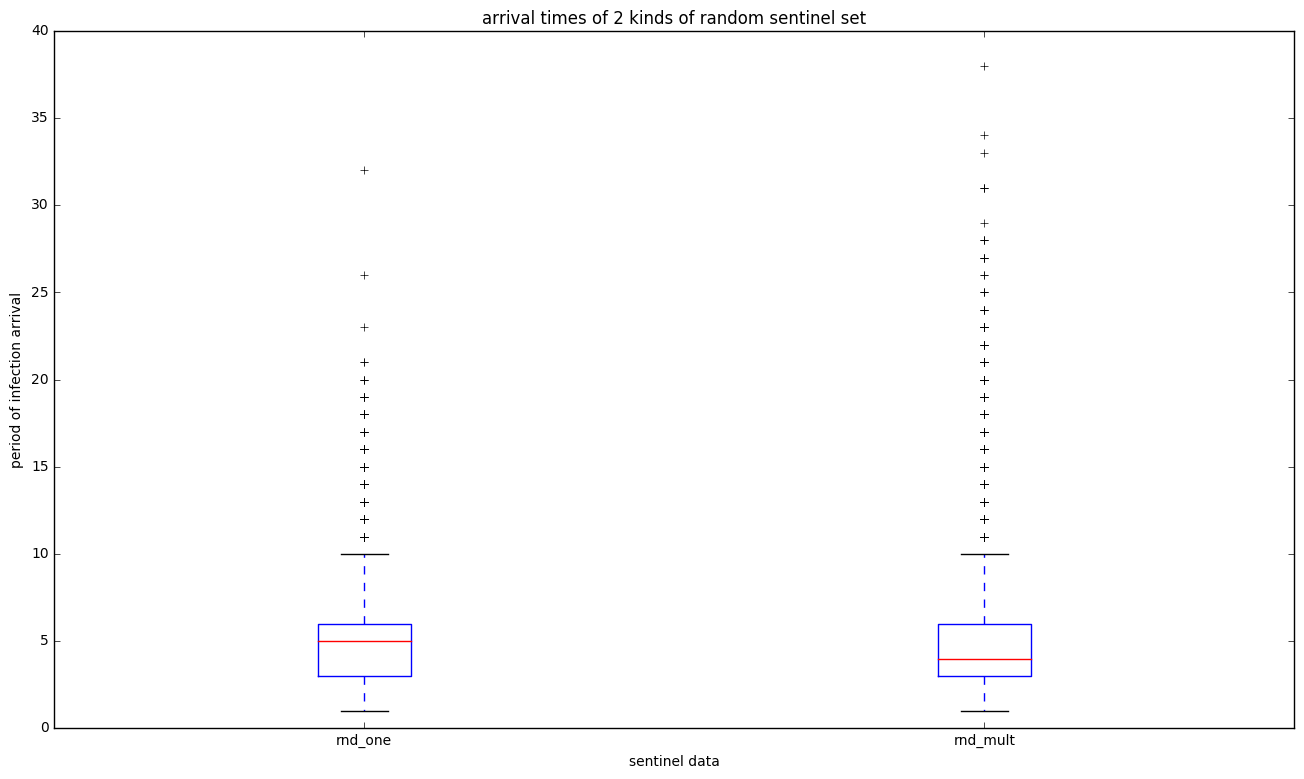

In [13]:
width_image = 16
height_image = 9
box_plot_random = []
names = ['rnd_one','rnd_mult']
for rank in names:
    box_plot = []
    huge_array = list_of_results[rank]
    for x in huge_array:
        box_plot=box_plot+x
    box_plot_random.append(box_plot)
    print "the average arrival for",rank,"is:",np.mean(box_plot)
fig, ax = plt.subplots(figsize=(width_image, height_image))
plt.boxplot(box_plot_random)
ax.set_xticklabels(names)
plt.ylabel("period of infection arrival")
plt.xlabel("sentinel data")
plt.title("arrival times of 2 kinds of random sentinel set")
#plt.savefig("pics/"+rank+".png")
plt.show()
plt.close()
plt.clf()


### Part 2.3
<p>It is now time to use the time arrivals distributions in order to show a box plot for every different selection of sentinel and eventually decide which method is the best. The following code shows a different plot of distribution for each selection. Furthermore, if you check in the cell after, we can compare such distribution in a better way. Indeed by plotting them in the same figure and ordering them by average time arrival, we have a better sense of the behaviours of different kind of sentinels. We will go through each metric to explain them.</p>
<ul>
<li>(rnd_one and rnd_mult) The random distributions  are as expected the mildest, as they stay in the middle separating the sentinels with lower period of arrival from the sentinels with and higher period.</li><br>
<li>(T_degr and B_degr) The higher the degree (the number of connections from a node to other nodes), the quicker a node is infected and vice versa.</li><br>
<li>(T_pr and B_pr) The higher the pagerank (a metric that takes into account the flows of influence in the graph), the more relevant is the node in the graph, the quicker a node is infected and vice versa. It has to be said that this graph is undirected, so the pagerank is not as relevant.</li><br>
<li>(T_hubs, B_hubs, T_auth and B_auth) Same thing, being the graph undirected there is really not much of a difference between hubs and authorities within the HITS algorithm, but anyway the more edges the node has, the higher the node scores (both of them: authority and hub scores). The higher the scores a node will have, the higher the degree of course. As we already said, the higher the degree, the smaller the time arrival and vice versa.</li><br>
<li>(T_eig and B_eig) The eigenvector centrality also called eigen centrality is the measure of the influence of a node over the network. It is indeed a variant of the pagerank, therefore it offers the same explanation of why the top-rank eigenvector centrality nodes have a lower time of arrival.</li><br>
<li>(T_betw and B_betw) The betweenness measures the number of times a node is within the shortest path between other 2 nodes. If a node is the only one both connected to 2 different clusters, it has an higher betweenness. This measure is important even more in a social network like Facebook, where unexpected mutual friendship have a key role in linking people. Of course the higher the betweenness, the more likely the node will be hit by the infection while spreading from a cluster to another, the smaller the time of arrival will be.</li><br>
<li>(T_clos and B_clos) Finally the closeness represents the average shortest path with the other nodes a node has. This means that nodes that are more central will have higher closeness. That is because, being centrally placed, those nodes will have less steps to do to be connected to most of the other nodes, especially if we compare them to a node with a low degree at the margin of the graph. In terms of infection spreading, of course, the higher the closeness the more central is the node, the more likely it will be connected to other infected nodes, the sooner it will be infected, the smaller the time of arrival and vice versa.</li>
</ul>
<p>By comparing the time arrivals of all those different set of sentinels, we can convey that the best kind of selection is given by the top scores of closeness, betweenness and degree centralities. The distributions of those 3 selections have about the same average time arrival, around 2.5.</p>
<p>The top scores for pagerank, eigencentrality and HITS (hubs and authorities) give instead a bit lower performance, being the time of arrivals around 4. This might be because they measure influence floating between nodes and they work especially in directed graphs, where we have instead a Facebook graph where friendships are undirected.</p>
<p>The worst are the random selections which, even by redrawing multiple times to decrease the randomness effect, have an average of 5. Of course all the selection given by the lowest scores of any centrality (in the far right in the plot) have the opposite effect as explained before.</p>

the average time arrival for T_eig is : 4.653


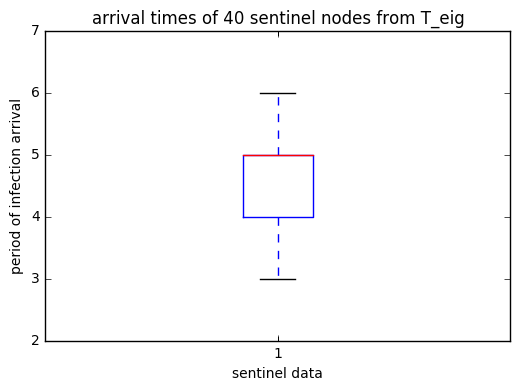

the average time arrival for B_pr is : 5.80496987952


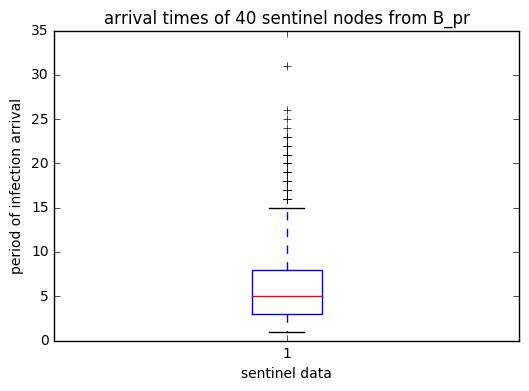

the average time arrival for B_degr is : 7.97457627119


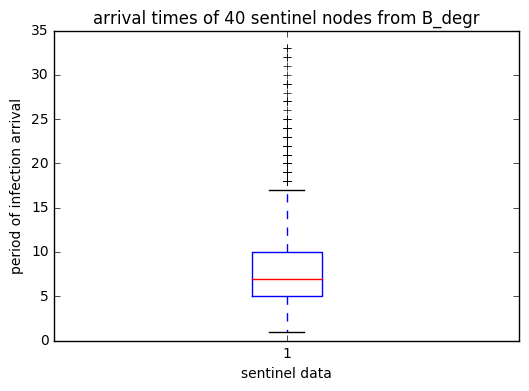

the average time arrival for T_clos is : 2.3858974359


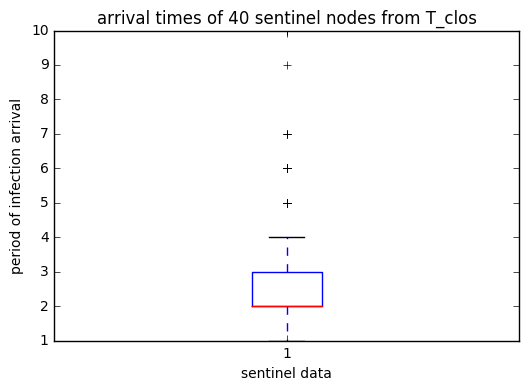

the average time arrival for B_eig is : 12.2497998399


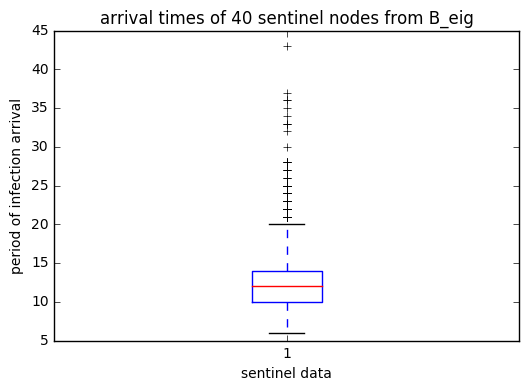

the average time arrival for B_clos is : 12.4037755637


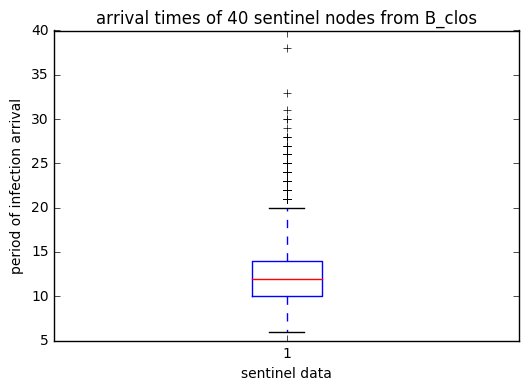

the average time arrival for T_auth is : 4.543


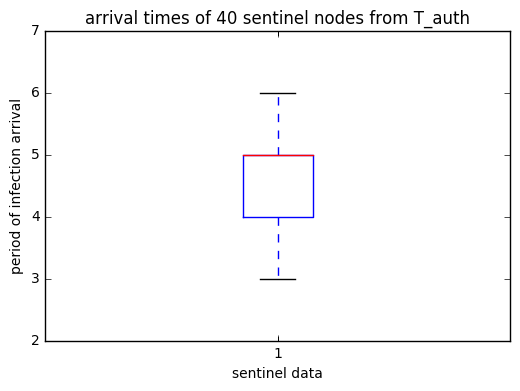

the average time arrival for B_auth is : 12.5047106326


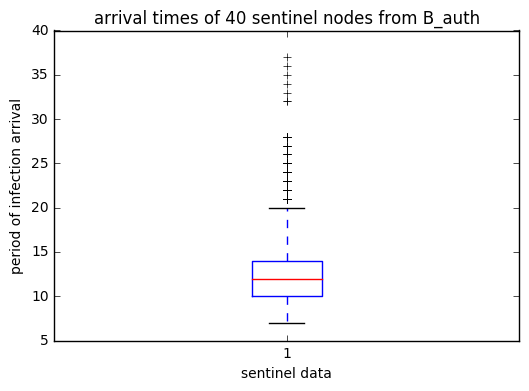

the average time arrival for rnd_mult is : 4.72567376602


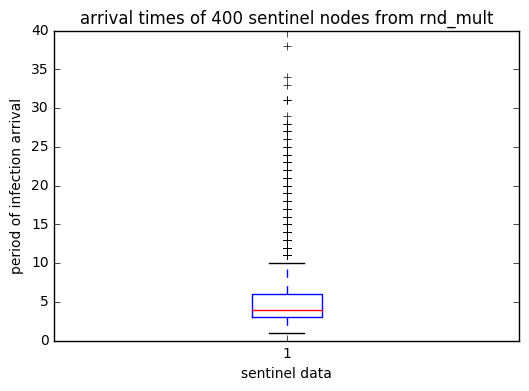

the average time arrival for T_hubs is : 4.47825


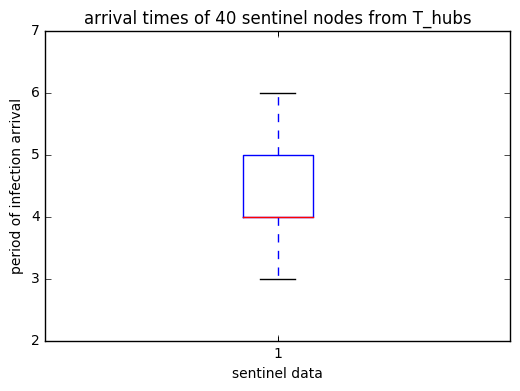

the average time arrival for B_hubs is : 12.3357992074


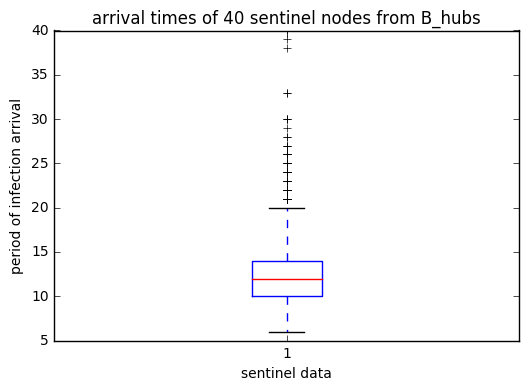

the average time arrival for T_betw is : 4.19938016529


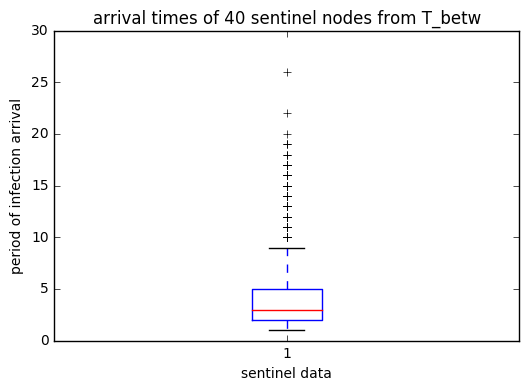

the average time arrival for T_degr is : 3.36487179487


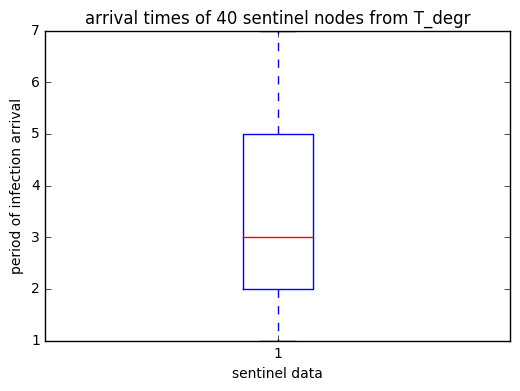

the average time arrival for B_betw is : 10.6636304489


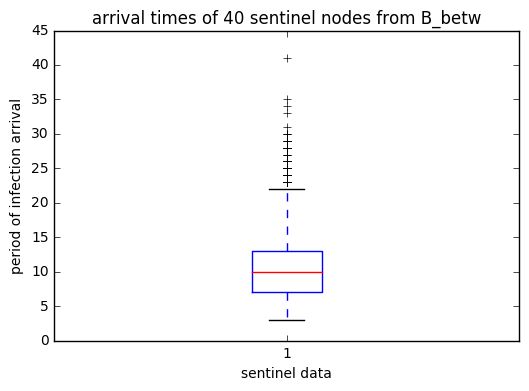

the average time arrival for T_pr is : 4.50193448543


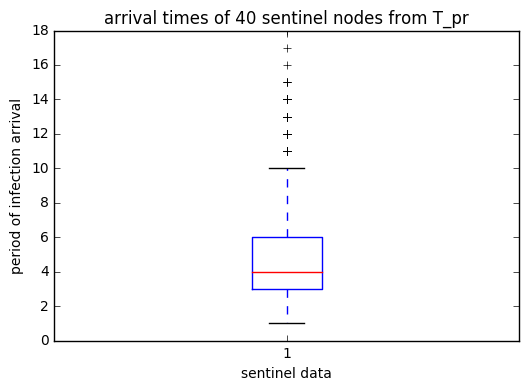

the average time arrival for rnd_one is : 5.32145584118


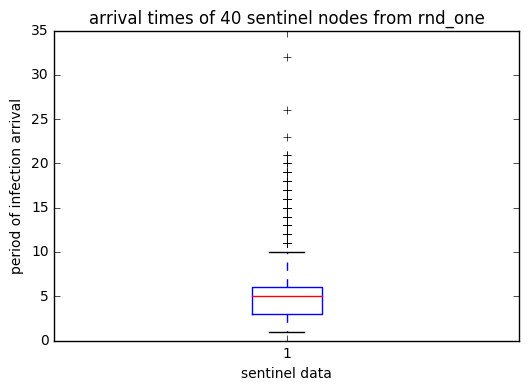

In [14]:
for rank in list_of_results:
    box_plot = []
    huge_array = list_of_results[rank]
    for x in huge_array:
        box_plot=box_plot+x
    #plt.figure(figsize=(width_image, height_image))
    print "the average time arrival for",rank,"is :",np.mean(box_plot) 
    plt.boxplot(box_plot)
    plt.ylabel("period of infection arrival")
    plt.xlabel("sentinel data")
    plt.title("arrival times of "+str(len(huge_array))+" sentinel nodes from "+rank)
    #plt.savefig("pics/"+rank+".png")
    plt.show()
    plt.close()
    plt.clf()


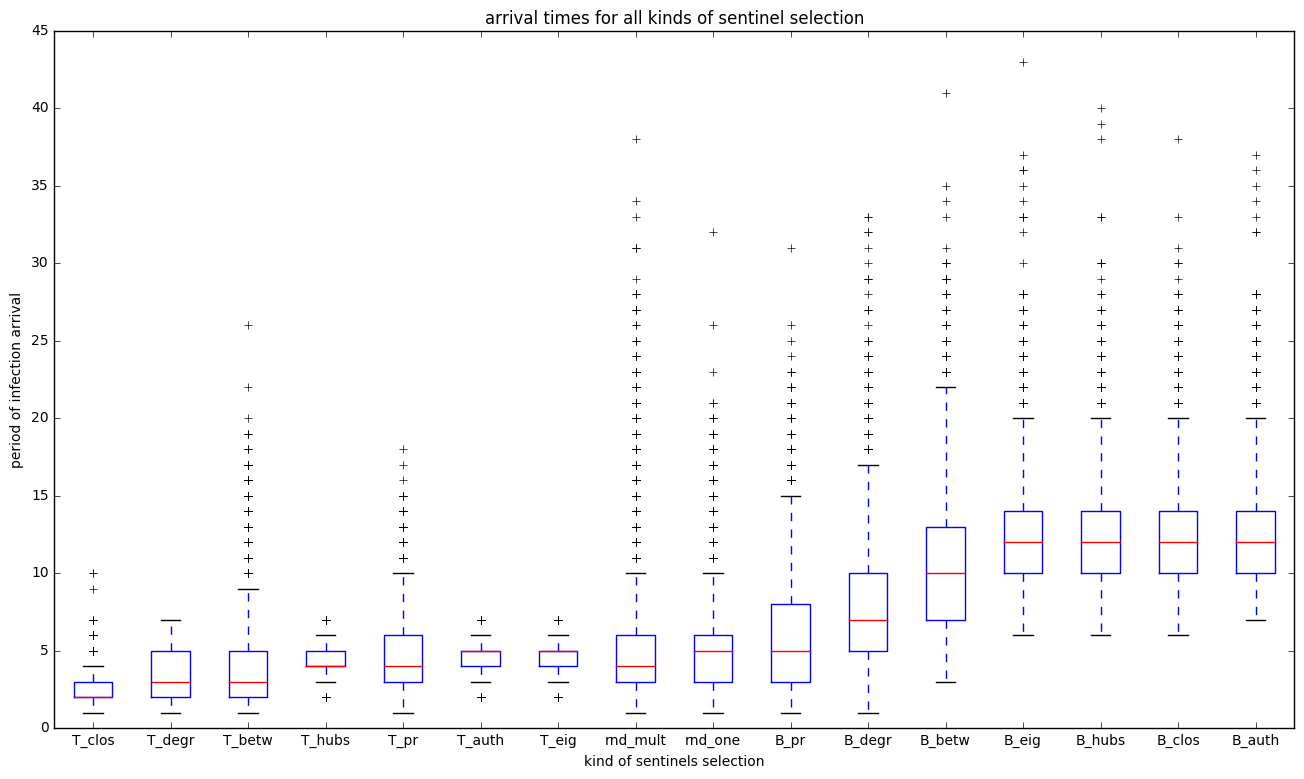

In [31]:
width_image = 16
height_image = 9
box_plot_multiple = []
names = []
means = []
for rank in list_of_results:
    box_plot = []
    huge_array = list_of_results[rank]
    names.append(rank)
    for x in huge_array:
        box_plot=box_plot+x
    means.append(np.mean(box_plot))
    box_plot_multiple.append(box_plot)

d_toOrder = zip(box_plot_multiple,means,names)
d_toOrder.sort(key = lambda t: t[1])
box_plot_multiples = [x[0] for x in d_toOrder]
names = [x[2] for x in d_toOrder]
fig, ax = plt.subplots(figsize=(width_image, height_image))
#plt.figure(figsize=(width_image, height_image))
plt.boxplot(box_plot_multiples)
plt.ylabel("period of infection arrival")
plt.xlabel("kind of sentinels selection")
plt.title("arrival times for all kinds of sentinel selection")
ax.set_xticklabels(names)
#plt.savefig("pics/all"+".png")
plt.show()
plt.clf()
plt.close()

### Part 3.1 - 3.2
<p>We will now use a set of random sentinels (white dots in figure) to get a local graph. This subgraphhwillbe made of all the random sentinelscand all their neighbours. We will then have all the edges between all those nodes.</p>
<p>As you can see this way we get a graph not fully connected. From 40 random sentinels we get a graph made of 3 components and not 40 components because probably some sentinels are neighbours themselves or have some (thinking back that this is a Facebook network) mutual friendships (mutual neighbours). This reduces a lot the number of components. </p>
<p>Our purpose here is to select another set of sentinels among the nodes in this local graph, so that the average arrival time will decrease. We are still using the sentinels of "rnd_one" were the average time arrival (over 100 realizations of the epidemic) is 5.32145584118. We want to find a new set of sentinels with an average lower than that.</p>
<p>From what we could see in 2.2, the nodes with the highest closeness, betweenness and/or degree scores are the ones that reduce better the arrival time. Let's compute those centralities for the subgraph and select the 40 nodes with the highest scores. Then we can use them as sentinel in the overall graph.</p> 
<p>Since the subgraph had 3 different components, I had to get sentinels from all components even though the highest scores where only in the largest component (the red one). To do this I implemented my code to get the sentinels in the different components with the same proportion of the number of nodes (70% from the bigger component, 27% from the medium one and 3% from the smaller one).</p>
<p>The algorithm is able to pick sentinels from different components until it doesn't reach the correct amount (40 sentinels) with the correct proportions (70% of sentinels from the first components, .. ). Read the prints of the algorithm and look at the figure to see the details.</p>
<p>After selecting this way our new 40 sentinels (the orange dots in the figure), we can use the method defined before to compute a new distribution of time arrival over 100 realizations. The result is way better than the random one, being now around 3 the average time arrival.</p>
<p>Even though we did not have the information regarding the full graph, we were still able to select sentinels so that we could lower the time of arrival. In a real word scenario this would make us aware sooner of an epidemic of a disease or of spreading of an internet virus.</p>

number of components: 3
number of nodes for Component #1 : 701 ( 73.0969760167 %)
We will select 29 / 40 sentinels ( 73.0969760167 %) from this component.
+ 7 new sentinels from closeness scores
+ 7 new sentinels from degree scores
+ 5 new sentinels from betweenness scores
+ 3 new sentinels from closeness scores
+ 2 new sentinels from degree scores
+ 3 new sentinels from betweenness scores
+ 3 new sentinels from closeness scores
number of nodes for Component #2 : 221 ( 23.0448383733 %)
We will select 9 / 40 sentinels ( 23.0448383733 %) from this component.
+ 2 new sentinels from closeness scores
+ 1 new sentinels from degree scores
+ 3 new sentinels from betweenness scores
+ 2 new sentinels from closeness scores
+ 1 new sentinels from degree scores
number of nodes for Component #3 : 37 ( 3.85818561001 %)
We will select 1 / 40 sentinels ( 3.85818561001 %) from this component.
+ 1 new sentinels from closeness scores
number of nodes: 959
number of edges: 20616
we have selected 40 new sent

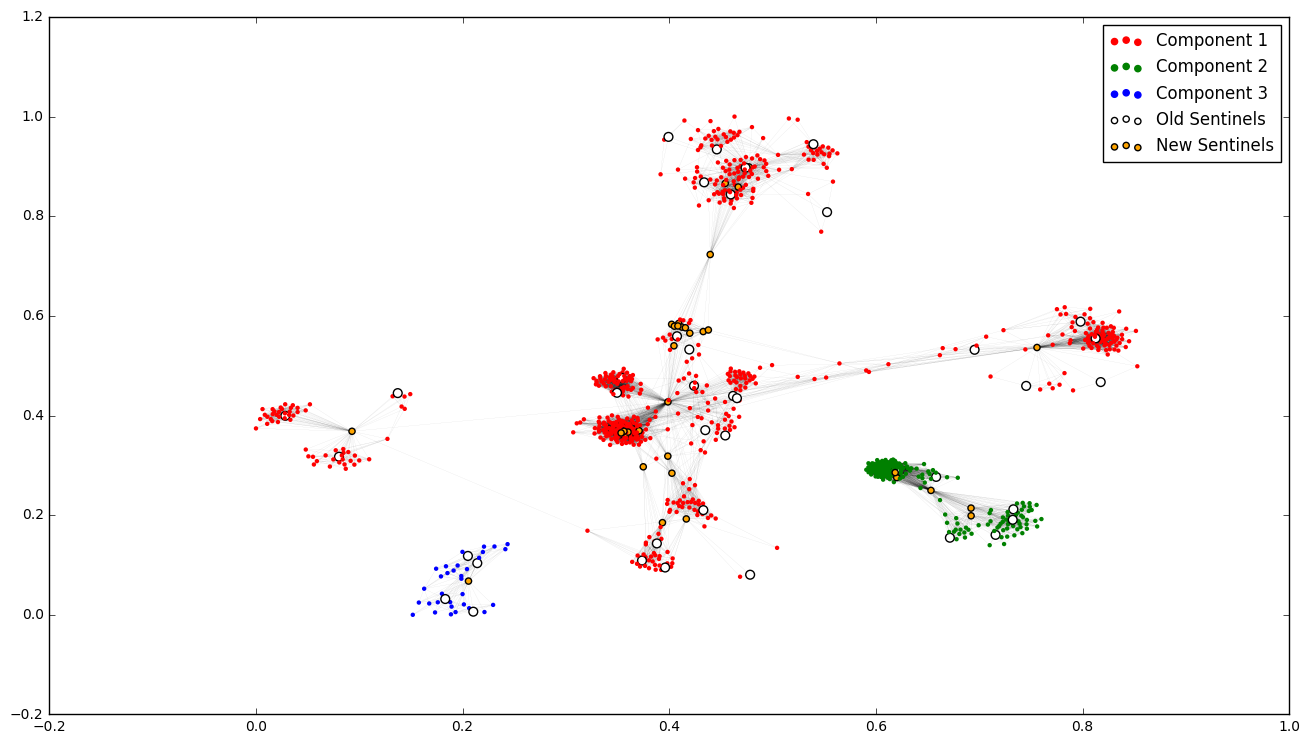

In [44]:
allNodes = []
d_attr = {}
G_local = nx.Graph()
for x in possible_sentinels["rnd_one"]:
    neighX = G.neighbors(x)
    allNodes = list(set(allNodes+neighX))
    for y in neighX:
        d_attr[y] = 'neighbour'
        G_local.add_edge(x,y)
for x in random_RANK:
    neighX = G.neighbors(x)
    for y in neighX:
        neighY = G.neighbors(y)
        for z in neighY:
            if z in allNodes:
                G_local.add_edge(y,z)
                
comp = list(nx.connected_component_subgraphs(G_local))


for x in random_RANK:
    d_attr[x] = 'original'
    
nx.set_node_attributes(G_local,'kind',d_attr)



d_comp = {}
i = 0
for x in comp:
    for y in x.nodes():
        if i == 0:
            d_comp[y]='comp_1'
        elif i == 1:
            d_comp[y]='comp_2'
        elif i == 2:
            d_comp[y]='comp_3'
    i += 1
nx.set_node_attributes(G_local,'comp',d_comp)
N_local = nx.number_of_nodes(G_local)
print "number of components:", nx.number_connected_components(G_local)
sentinels_selected = set([])
oldLen = 0
for i in range(0,len(comp)):
    size_comp = len(comp[i])
    perc_comp = size_comp/float(N_local)
    print "number of nodes for Component #"+str(i+1),":",size_comp,"(",perc_comp*100,"%)"
    perc_comp_int = int(perc_comp*num_of_sentinels)
    print "We will select",perc_comp_int,"/",num_of_sentinels,"sentinels (",perc_comp*100,"%) from this component."
    local_closeness = nx.closeness_centrality(comp[i])
    local_degree = nx.degree_centrality(comp[i])
    local_betweeness = nx.betweenness_centrality(comp[i])
    list_centr = [local_closeness,local_degree,local_betweeness]
    names_centr = ["closeness","degree","betweenness"]
    h = 0
    amount = 0
    c = 0
    while amount < perc_comp_int:
        sort_zip_loc_clos = sorted(list_centr[h].items(), key=operator.itemgetter(1),reverse=True)
        topHowMany = np.max([1,int(perc_comp_int/4)])+c
        sentinels_selected = sentinels_selected.union(set([x[0] for x in sort_zip_loc_clos][:topHowMany]))
        increase = len(sentinels_selected)-oldLen
        print "+",increase,"new sentinels from", names_centr[h],"scores"
        oldLen = len(sentinels_selected)
        h+=1
        if h ==3:
            h = 0
        c+=1
        amount+=increase
sentinels_selected = list(sentinels_selected)[:num_of_sentinels]
print "number of nodes:", N_local
print "number of edges:", nx.number_of_edges(G_local)
print "we have selected",len(sentinels_selected),"new sentinels."
size_node = 10
width_edge = 0.02
width_image = 16
height_image = 9

pos = nx.spring_layout(G_local,k=2/np.sqrt(N_local))
size_nodes = []
border_nodes = []
for x in G_local.nodes():
    if x in sentinels_selected:
        border_nodes.append("black")
        size_nodes.append(size_node*2)
    else:
        if G_local.node[x]['kind'] in ['original']:
            size_nodes.append(size_node*4)
            border_nodes.append("black")
        if G_local.node[x]['kind'] in ['neighbour']:
            size_nodes.append(size_node)
            border_nodes.append("none")
    


colors_nodes = []
for x in G_local.nodes():
    if G_local.node[x]['kind'] in ['original']:
        colors_nodes.append('white')
    else:
        if x in sentinels_selected:
            colors_nodes.append('orange')
        else:
            if G_local.node[x]['comp'] in ['comp_1']:
                colors_nodes.append('red')
            if G_local.node[x]['comp'] in ['comp_2']:
                colors_nodes.append('green')
            if G_local.node[x]['comp'] in ['comp_3']:
                colors_nodes.append('blue')

        
plt.figure(figsize=(width_image, height_image))

nodes = nx.draw_networkx_nodes(G_local, pos,node_size=size_nodes,node_color  = colors_nodes)
nodes.set_edgecolor(border_nodes)
nx.draw_networkx_edges(G_local, pos,width =width_edge)

red_patch = plt.scatter([],[], marker='o', color='red')
green_patch = plt.scatter([],[], marker='o', color='green')
blue_patch = plt.scatter([],[], marker='o', color='blue')
border_patch = plt.scatter([],[], marker='o',facecolors='none')
new_sent_patch = plt.scatter([],[], marker='o',facecolors='orange')

plt.legend((red_patch,green_patch,blue_patch,border_patch,new_sent_patch),("Component 1","Component 2","Component 3","Old Sentinels","New Sentinels"))

plt.show()

In [40]:
result = compute_time_arrivals(sentinels_selected,random_pick=0)

---
beta: 0.15
mu: 0.1
---

pick : 0 ; iter. : 10

pick : 0 ; iter. : 20

pick : 0 ; iter. : 30

pick : 0 ; iter. : 40

pick : 0 ; iter. : 50

pick : 0 ; iter. : 60

pick : 0 ; iter. : 70

pick : 0 ; iter. : 80

pick : 0 ; iter. : 90

pick : 0 ; iter. : 100



the average arrival time for the new set of sentinels is:
2.95818368394


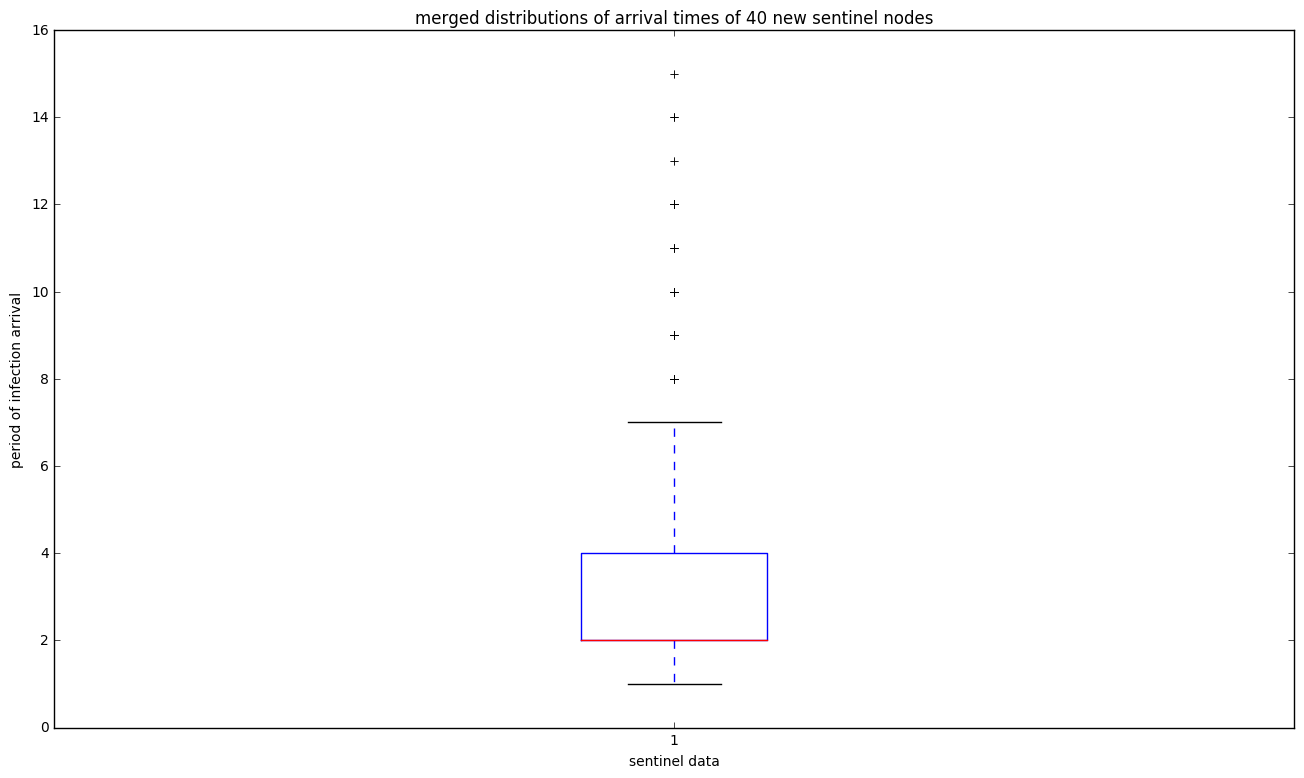

In [42]:
all_values = []
for x in result:
    all_values = all_values + x
print "the average arrival time for the new set of sentinels is:"
NEW_mean = np.mean(all_values)
print NEW_mean
plt.figure(figsize=(width_image, height_image))
plt.boxplot(all_values)
#plt.plot(range(1,len(means)+1),means)
plt.ylabel("period of infection arrival")
plt.xlabel("sentinel data")
plt.title("merged distributions of arrival times of "+str(len(huge_array))+" new sentinel nodes")
plt.show()
plt.close()
plt.clf()

### Part 3.2
<p>I close this project by plotting the distribution of time arrivals of the sentinels selected from the local graph. This way we can better compare them with the other distributions. The figure is below and the added boxplot has label "NEW".</p>


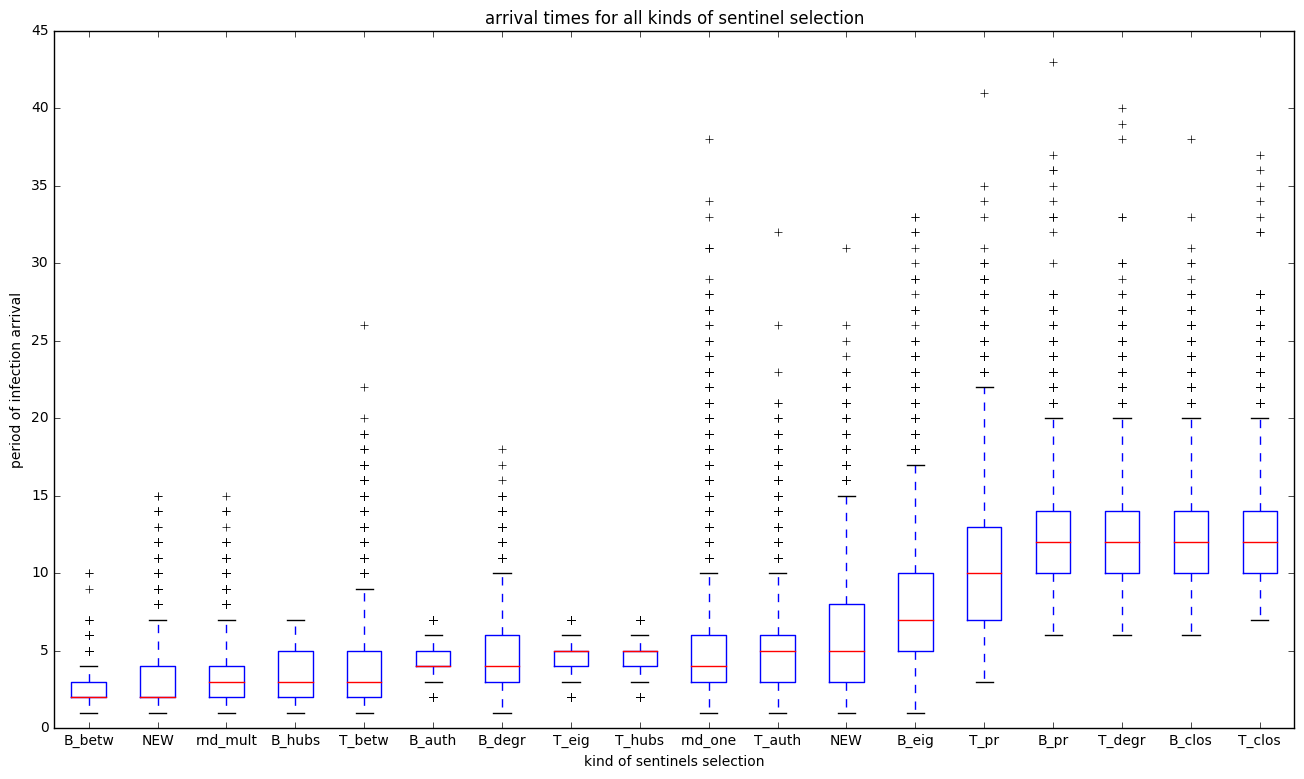

In [43]:
box_plot_multiple.append(all_values)
names.append("NEW")
means.append(NEW_mean)
d_toOrder = zip(box_plot_multiple,means,names)
d_toOrder.sort(key = lambda t: t[1])
box_plot_multiples = [x[0] for x in d_toOrder]
names = [x[2] for x in d_toOrder]
fig, ax = plt.subplots(figsize=(width_image, height_image))
#plt.figure(figsize=(width_image, height_image))
plt.boxplot(box_plot_multiples)
plt.ylabel("period of infection arrival")
plt.xlabel("kind of sentinels selection")
plt.title("arrival times for all kinds of sentinel selection")
ax.set_xticklabels(names)
#plt.savefig("pics/all"+".png")
plt.show()
plt.clf()
plt.close()